<br>

<center><img src="https://www.htu.edu.jo/images/ThumbnailsCoverPhotos/HTU%20Logo-250px.png" alt="HTU"  width="180px" align="center">


<br>

<p>

**Natural Language Processing**

10204351

Section (3)

**Implement a natural language processing application**

**Submitted to**

Eng. Yara Alharahsheh

**Submitted on**

June 12th, 2024

**Submitted by**

Marwan Tarek Shafiq Al Farah

**Student ID**

21110011

Spring 2023 – 2024
</p></center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from gensim.models import Word2Vec

from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModel, GPT2Tokenizer, GPT2ForSequenceClassification

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
from keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Loading the Dataset**

In [ ]:
df_temp = pd.read_excel('/content/drive/MyDrive/News_train.xlsx').sample(frac=1, random_state=42).reset_index(drop=True)
df_test = pd.read_excel('/content/drive/MyDrive/News_test.xlsx').sample(frac=1, random_state=42).reset_index(drop=True)

# **Preprocessing the Dataset**

In [ ]:
def clean_text (text):

    text = text.replace('_', ' ')

    pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
    text = pattern.sub(r"\1\1", text)

    tshkil = re.compile("ّ|َ|ً|ُ|ٌ|ِ|ٍ|ْ|ـ", re.VERBOSE)
    text = re.sub(tshkil, '', text)
    text = re.sub(r'[^\w\s]',' ',text)

    text = text.strip()
    text = re.sub(r'(.)\1+', r"\1\1", text)
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ة", "ه", text)
    text = re.sub(r'[A-Za-z0-9]', r'', text)

    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in set(stopwords.words('arabic'))]

    return ' '.join(tokens)

In [ ]:
df_temp['News'] = df_temp['News'].apply(clean_text)
df_test['News'] = df_test['News'].apply(clean_text)

In [ ]:
X_temp = df_temp['News']
y_temp = df_temp['Type']
X_test = df_test['News']
y_test = df_test['Type']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [ ]:
label_encoder = LabelEncoder()
y_temp_enc = label_encoder.fit_transform(y_temp)
y_test_enc = label_encoder.transform(y_test)

# **Word Representation**

## **TF-IDF**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=300)
x_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
x_val_tfidf = tfidf_vectorizer.transform(X_val).toarray()

## **Bag-of-Words**

In [ ]:
count_vectorizer = CountVectorizer(max_features=300)
x_train_bow = count_vectorizer.fit_transform(X_train).toarray()
x_val_bow = count_vectorizer.transform(X_val).toarray()

## **Word2Vec**

### **Twitter**

In [ ]:
w2v_model_twitter = Word2Vec.load('/content/drive/MyDrive/full_grams_cbow_300_twitter/full_grams_cbow_300_twitter.mdl')

In [ ]:
OOV_tokens_twitter = []
train_tokens_twitter = []
val_tokens_twitter = []

def word_2_vec_twitter(sent, model, data):
  w2v_embeddings = []
  tokens = sent.split()
  for word in tokens:
    try:
      if data == 'train':
        w2v_embeddings.append(model.wv[word])
        train_tokens_twitter.append(word)
      else:
        w2v_embeddings.append(model.wv[word])
        val_tokens_twitter.append(word)
    except:
      OOV_tokens_twitter.append(word)
      continue
  if len(w2v_embeddings) == 0:
    return None
  return sum(w2v_embeddings)/len(w2v_embeddings)

x_train_w2v_twitter_embeddings = np.stack(X_train.apply(lambda sent: word_2_vec_twitter(sent, w2v_model_twitter, 'train')))
x_val_w2v_twitter_embeddings = np.stack(X_val.apply(lambda sent: word_2_vec_twitter(sent, w2v_model_twitter, 'val')))

### **Wikipedia**

In [ ]:
w2v_model_wiki = Word2Vec.load('/content/drive/MyDrive/full_grams_cbow_300_wiki/full_grams_cbow_300_wiki.mdl')

In [ ]:
OOV_tokens_wiki = []
train_tokens_wiki = []
val_tokens_wiki = []

def word_2_vec_wiki(sent, model, data):
  w2v_embeddings = []
  tokens = sent.split()
  for word in tokens:
    try:
      if data == 'train':
        w2v_embeddings.append(model.wv[word])
        train_tokens_wiki.append(word)
      else:
        w2v_embeddings.append(model.wv[word])
        val_tokens_wiki.append(word)
    except:
      OOV_tokens_wiki.append(word)
      continue
  if len(w2v_embeddings) == 0:
    return None
  return sum(w2v_embeddings)/len(w2v_embeddings)

x_train_w2v_wiki_embeddings = np.stack(X_train.apply(lambda sent: word_2_vec_wiki(sent, w2v_model_wiki, 'train')))
x_val_w2v_wiki_embeddings = np.stack(X_val.apply(lambda sent: word_2_vec_wiki(sent, w2v_model_wiki, 'test')))

## **BERT**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
model = AutoModel.from_pretrained("aubmindlab/bert-base-arabertv2")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(64000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def get_bert_embeddings(sentences, model, tokenizer, device, max_length=None):
    # Encode the inputs
    if max_length == None:
        encoded_input = tokenizer(sentences, padding=True, return_tensors='pt')
    else:
        encoded_input = tokenizer(sentences, padding="max_length", truncation=True, return_tensors='pt', max_length=max_length)
    encoded_input = {key: value.to(device) for key, value in encoded_input.items()}  # Move input to GPU

    with torch.no_grad():
        model_output = model(**encoded_input)

    embeddings = model_output.last_hidden_state
    return embeddings.cpu().numpy()

In [ ]:
x_train_bert = get_bert_embeddings(X_train.tolist(), model, tokenizer, device)
x_val_bert = get_bert_embeddings(X_val.tolist(), model, tokenizer, device, x_train_bert.shape[1])

# **Modeling**

## **Baseline Models (Naïve Bayes)**

### **TF-IDF**

In [ ]:
nb = GaussianNB()
nb.fit(x_train_tfidf, y_train)
y_pred = nb.predict(x_val_tfidf)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

    economic       0.39      0.65      0.49       188
    politics       0.97      0.47      0.63       605
       sport       0.68      0.83      0.75       188
        tech       0.10      0.84      0.17        19

    accuracy                           0.58      1000
   macro avg       0.53      0.70      0.51      1000
weighted avg       0.79      0.58      0.62      1000



### **Bag-of-Words**

In [ ]:
nb = GaussianNB()
nb.fit(x_train_bow, y_train)
y_pred = nb.predict(x_val_bow)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

    economic       0.39      0.65      0.49       188
    politics       0.97      0.46      0.62       605
       sport       0.68      0.85      0.75       188
        tech       0.10      0.84      0.17        19

    accuracy                           0.57      1000
   macro avg       0.53      0.70      0.51      1000
weighted avg       0.79      0.57      0.61      1000



### **Word2Vec (Twitter)**

In [ ]:
nb = GaussianNB()
nb.fit(x_train_w2v_twitter_embeddings, y_train)
y_pred = nb.predict(x_val_w2v_twitter_embeddings)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

    economic       0.78      0.83      0.81       188
    politics       0.95      0.89      0.92       605
       sport       0.98      0.91      0.95       188
        tech       0.32      0.95      0.47        19

    accuracy                           0.89      1000
   macro avg       0.76      0.90      0.79      1000
weighted avg       0.91      0.89      0.89      1000



### **Word2Vec (Wikipedia)**

In [ ]:
nb = GaussianNB()
nb.fit(x_train_w2v_wiki_embeddings, y_train)
y_pred = nb.predict(x_val_w2v_wiki_embeddings)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

    economic       0.77      0.79      0.78       188
    politics       0.94      0.88      0.91       605
       sport       0.97      0.91      0.94       188
        tech       0.29      1.00      0.45        19

    accuracy                           0.87      1000
   macro avg       0.74      0.89      0.77      1000
weighted avg       0.90      0.87      0.88      1000



### **BERT**

In [ ]:
nb = GaussianNB()
nb.fit(x_train_bert.mean(axis=1), y_train)
y_pred_nb = nb.predict(x_val_bert.mean(axis=1))
print(classification_report(y_val, y_pred_nb))

              precision    recall  f1-score   support

    economic       0.81      0.82      0.82       188
    politics       0.93      0.91      0.92       605
       sport       0.95      0.91      0.93       188
        tech       0.38      0.74      0.50        19

    accuracy                           0.89      1000
   macro avg       0.77      0.84      0.79      1000
weighted avg       0.90      0.89      0.89      1000



## **Testing Models**

### **Naïve Bayes**

In [ ]:
x_temp_bert = get_bert_embeddings(X_temp.tolist(), model, tokenizer, device)
x_test_bert = get_bert_embeddings(X_test.tolist(), model, tokenizer, device, x_temp_bert.shape[1])

In [ ]:
nb = GaussianNB()
nb.fit(x_temp_bert.mean(axis=1), y_temp)
y_pred_nb = nb.predict(x_test_bert.mean(axis=1))
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

    economic       0.73      0.70      0.72       200
    politics       0.87      0.90      0.89       512
       sport       0.98      0.93      0.95       200
        tech       0.72      0.70      0.71        88

    accuracy                           0.85      1000
   macro avg       0.83      0.81      0.82      1000
weighted avg       0.85      0.85      0.85      1000



### **SVM**

In [ ]:
svm = SVC()
svm.fit(x_temp_bert.mean(axis=1), y_temp)
y_pred = svm.predict(x_test_bert.mean(axis=1))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    economic       0.79      0.68      0.73       200
    politics       0.83      0.96      0.89       512
       sport       0.97      0.96      0.96       200
        tech       0.92      0.40      0.56        88

    accuracy                           0.85      1000
   macro avg       0.88      0.75      0.78      1000
weighted avg       0.86      0.85      0.84      1000



### **Bidirectional LSTM**

In [ ]:
input_shape = (x_temp_bert.shape[1], x_temp_bert.shape[2])
model = Sequential()
model.add(Bidirectional(LSTM(units=300, input_shape=input_shape, return_sequences=False)))
model.add(Dense(4, activation='sigmoid'))
model.build(input_shape=(None, *input_shape))

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 600)               2565600   
 al)                                                             
                                                                 
 dense (Dense)               (None, 4)                 2404      
                                                                 
Total params: 2568004 (9.80 MB)
Trainable params: 2568004 (9.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(x_temp_bert, to_categorical(y_temp_enc), epochs=10, batch_size=32)

Epoch 1/10
157/157 [==============================] - 32s 183ms/step - loss: 0.3171 - accuracy: 0.8898
Epoch 2/10
157/157 [==============================] - 29s 185ms/step - loss: 0.2100 - accuracy: 0.9240
Epoch 3/10
157/157 [==============================] - 31s 199ms/step - loss: 0.1701 - accuracy: 0.9376
Epoch 4/10
157/157 [==============================] - 29s 187ms/step - loss: 0.1287 - accuracy: 0.9512
Epoch 5/10
157/157 [==============================] - 28s 176ms/step - loss: 0.0890 - accuracy: 0.9648
Epoch 6/10
157/157 [==============================] - 28s 177ms/step - loss: 0.0553 - accuracy: 0.9794
Epoch 7/10
157/157 [==============================] - 28s 180ms/step - loss: 0.0262 - accuracy: 0.9930
Epoch 8/10
157/157 [==============================] - 29s 186ms/step - loss: 0.0312 - accuracy: 0.9886
Epoch 9/10
157/157 [==============================] - 30s 192ms/step - loss: 0.0162 - accuracy: 0.9956
Epoch 10/10
157/157 [==============================] - 28s 180ms/step - l

In [ ]:
y_pred = np.argmax(model.predict(x_test_bert), axis=1)

32/32 [==============================] - 3s 80ms/step


In [ ]:
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    economic       0.77      0.74      0.75       200
    politics       0.87      0.94      0.90       512
       sport       0.95      0.95      0.95       200
        tech       0.93      0.57      0.70        88

    accuracy                           0.87      1000
   macro avg       0.88      0.80      0.83      1000
weighted avg       0.87      0.87      0.87      1000



### **BERT**

In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained('aubmindlab/bert-base-arabertv2')

In [ ]:
def tokenize_data_bert(texts, labels, max_len=57):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer_bert.encode_plus(
                            text,
                            add_special_tokens = True,
                            max_length = max_len,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt',
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

In [ ]:
X_temp_ids_bert, X_temp_masks_bert, y_temp_tensors_bert = tokenize_data_bert(X_temp, y_temp_enc)
X_test_ids_bert, X_test_masks_bert, y_test_tensors_bert = tokenize_data_bert(X_test, y_test_enc)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
batch_size = 32

In [ ]:
temp_data_bert = TensorDataset(X_temp_ids_bert, X_temp_masks_bert, y_temp_tensors_bert)
temp_dataloader_bert = DataLoader(temp_data_bert, batch_size=batch_size, shuffle=True)

test_data_bert = TensorDataset(X_test_ids_bert, X_test_masks_bert, y_test_tensors_bert)
test_dataloader_bert = DataLoader(test_data_bert, batch_size=batch_size, shuffle=False)

In [ ]:
model_bert = BertForSequenceClassification.from_pretrained(
    "aubmindlab/bert-base-arabertv2",
    num_labels = len(label_encoder.classes_),
    output_attentions = False,
    output_hidden_states = False,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer_bert = AdamW(model_bert.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model_bert.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def evaluate_bert(dataloader):
    model_bert.eval()
    eval_accuracy = 0
    nb_eval_steps = 0

    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model_bert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_accuracy += accuracy_score(label_ids, np.argmax(logits, axis=1))
        nb_eval_steps += 1

    avg_eval_accuracy = eval_accuracy / nb_eval_steps
    return avg_eval_accuracy

In [ ]:
epochs = 3

for epoch in range(epochs):
    model_bert.train()
    total_loss = 0

    for step, batch in enumerate(temp_dataloader_bert):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model_bert.zero_grad()
        outputs = model_bert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_bert.parameters(), 1.0)
        optimizer_bert.step()

    avg_train_loss = total_loss / len(temp_dataloader_bert)
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_train_loss}, Accuracy: {evaluate_bert(temp_dataloader_bert)}")

Epoch 1, Average Training Loss: 0.46534129440974276, Accuracy: 0.9406847133757962
Epoch 2, Average Training Loss: 0.21595962391869658, Accuracy: 0.9599920382165605
Epoch 3, Average Training Loss: 0.16068892154818887, Accuracy: 0.9812898089171974


In [ ]:
def classification_report_dataloader_bert(dataloader):
  y_pred = []
  y_true = []

  for batch in dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      with torch.no_grad():
          outputs = model_bert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

      logits = outputs[0]
      y_pred.extend(np.argmax(logits.detach().cpu().numpy(), axis=1))
      y_true.extend(b_labels.to('cpu').numpy())
  print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

In [ ]:
classification_report_dataloader_bert(test_dataloader_bert)

              precision    recall  f1-score   support

    economic       0.81      0.77      0.79       200
    politics       0.88      0.96      0.92       512
       sport       0.98      0.97      0.98       200
        tech       0.94      0.57      0.71        88

    accuracy                           0.89      1000
   macro avg       0.90      0.82      0.85      1000
weighted avg       0.89      0.89      0.88      1000



### **GPT**

In [ ]:
tokenizer_gpt = GPT2Tokenizer.from_pretrained('aubmindlab/aragpt2-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.52M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

In [ ]:
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token

In [ ]:
model_gpt = GPT2ForSequenceClassification.from_pretrained('aubmindlab/aragpt2-base', num_labels=len(label_encoder.classes_))
model_gpt.config.pad_token_id = tokenizer_gpt.pad_token_id

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at aubmindlab/aragpt2-base and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_data_gpt(texts, labels, max_len=60):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer_gpt.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

In [ ]:
X_temp_ids_gpt, X_temp_masks_gpt, y_temp_tensors_gpt = tokenize_data_gpt(X_temp, y_temp_enc)
X_test_ids_gpt, X_test_masks_gpt, y_test_tensors_gpt = tokenize_data_gpt(X_test, y_test_enc)

In [ ]:
batch_size = 32

In [ ]:
temp_data_gpt = TensorDataset(X_temp_ids_gpt, X_temp_masks_gpt, y_temp_tensors_gpt )
temp_dataloader_gpt = DataLoader(temp_data_gpt, batch_size=batch_size, shuffle=True)

test_data_gpt = TensorDataset(X_test_ids_gpt, X_test_masks_gpt, y_test_tensors_gpt)
test_dataloader_gpt = DataLoader(test_data_gpt, batch_size=batch_size, shuffle=False)

In [ ]:
optimizer_gpt = torch.optim.AdamW(model_gpt.parameters(), lr=2e-5, eps=1e-8)

In [ ]:
model_gpt.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(64000, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=4, bias=False)
)

In [ ]:
def evaluate_gpt(dataloader):
    model_gpt.eval()
    eval_accuracy = 0
    nb_eval_steps = 0

    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model_gpt(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_accuracy += accuracy_score(label_ids, np.argmax(logits, axis=1))
        nb_eval_steps += 1

    avg_eval_accuracy = eval_accuracy / nb_eval_steps
    return avg_eval_accuracy

In [ ]:
epochs = 3

for epoch in range(epochs):
    model_gpt.train()
    total_loss = 0

    for step, batch in enumerate(temp_dataloader_gpt):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model_gpt.zero_grad()
        outputs = model_gpt(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_gpt.parameters(), 1.0)
        optimizer_gpt.step()

    avg_train_loss = total_loss / len(temp_dataloader_gpt)
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_train_loss}, Accuracy: {evaluate_gpt(temp_dataloader_gpt)}")

Epoch 1, Average Training Loss: 0.6767658684284065, Accuracy: 0.9187898089171974
Epoch 2, Average Training Loss: 0.3022375313482087, Accuracy: 0.9434713375796179
Epoch 3, Average Training Loss: 0.23785273161283724, Accuracy: 0.9570063694267515


In [ ]:
def classification_report_dataloader_gpt(dataloader):
    y_pred = []
    y_true = []

    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model_gpt(b_input_ids, attention_mask=b_input_mask)

        logits = outputs.logits
        y_pred.extend(np.argmax(logits.detach().cpu().numpy(), axis=1))
        y_true.extend(b_labels.to('cpu').numpy())

    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

In [ ]:
classification_report_dataloader_gpt(test_dataloader_gpt)

              precision    recall  f1-score   support

    economic       0.83      0.70      0.76       200
    politics       0.85      0.97      0.91       512
       sport       0.96      0.97      0.97       200
        tech       0.96      0.50      0.66        88

    accuracy                           0.87      1000
   macro avg       0.90      0.79      0.82      1000
weighted avg       0.88      0.87      0.87      1000



# **Evaluation**

In [ ]:
file_path = '/content/drive/MyDrive/NLP Results.xlsx'

In [ ]:
excel_data = pd.ExcelFile(file_path)
sheet_names = excel_data.sheet_names

In [ ]:
def plot_sheet_data(sheet_name):

    df = pd.read_excel(file_path, sheet_name=sheet_name, index_col=0)

    df.plot(kind='bar', figsize=(10, 6), title=sheet_name)
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.ylim((0.3, 1))
    plt.title(f'{sheet_name} Results')
    plt.legend(loc='best')
    plt.show()

In [ ]:
def plot_accuracy_and_macro_averages(sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name, index_col=0)
    for column in df.columns:
        df[[column]].plot(kind='bar', figsize=(10, 6), title=f'{sheet_name} - {column}')
        plt.xlabel('Index')
        plt.ylabel(column)
        plt.ylim((0.6,1))
        plt.title(f'{sheet_name} - {column}')
        plt.show()

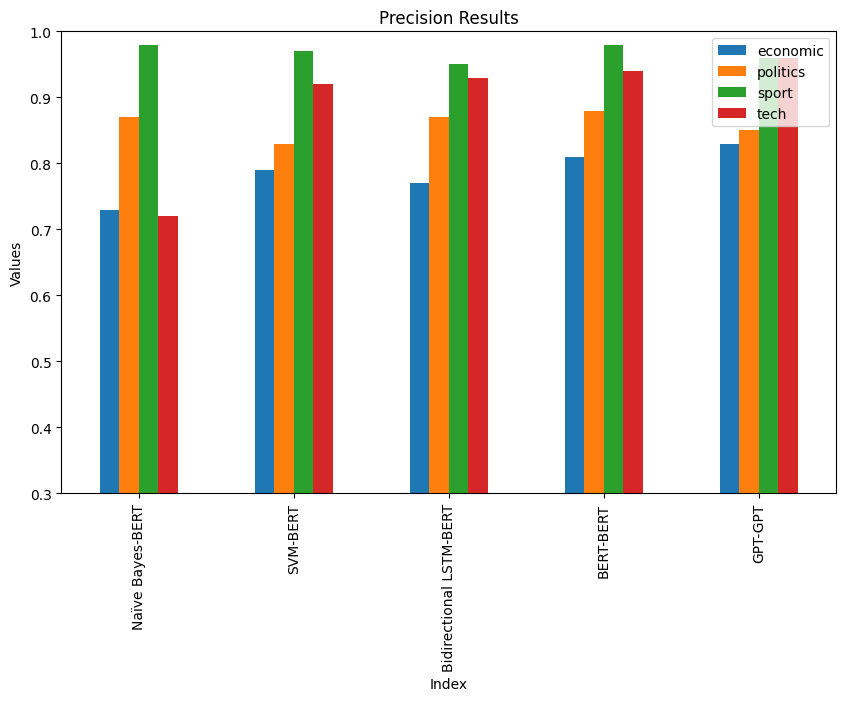

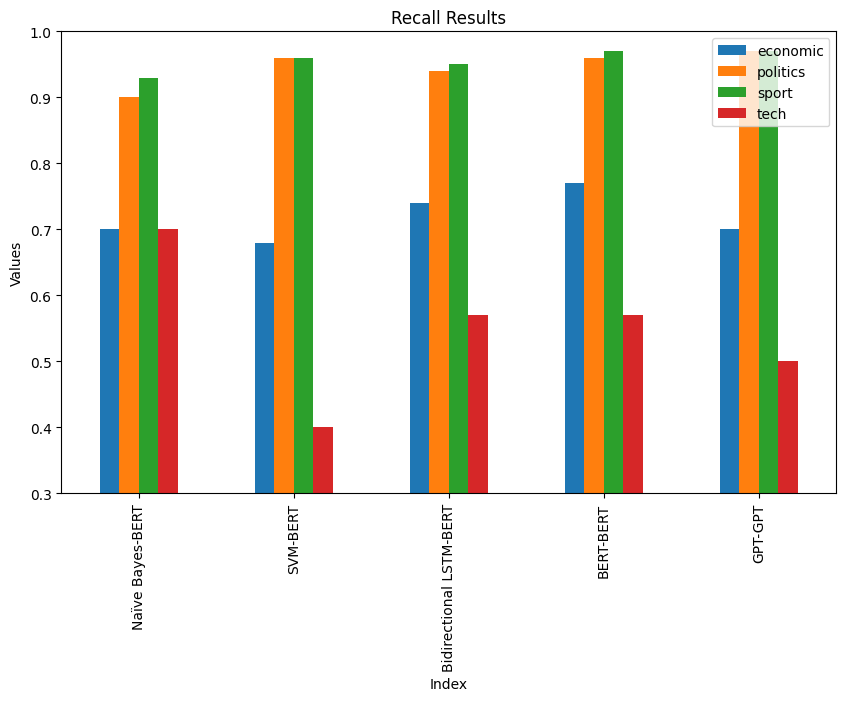

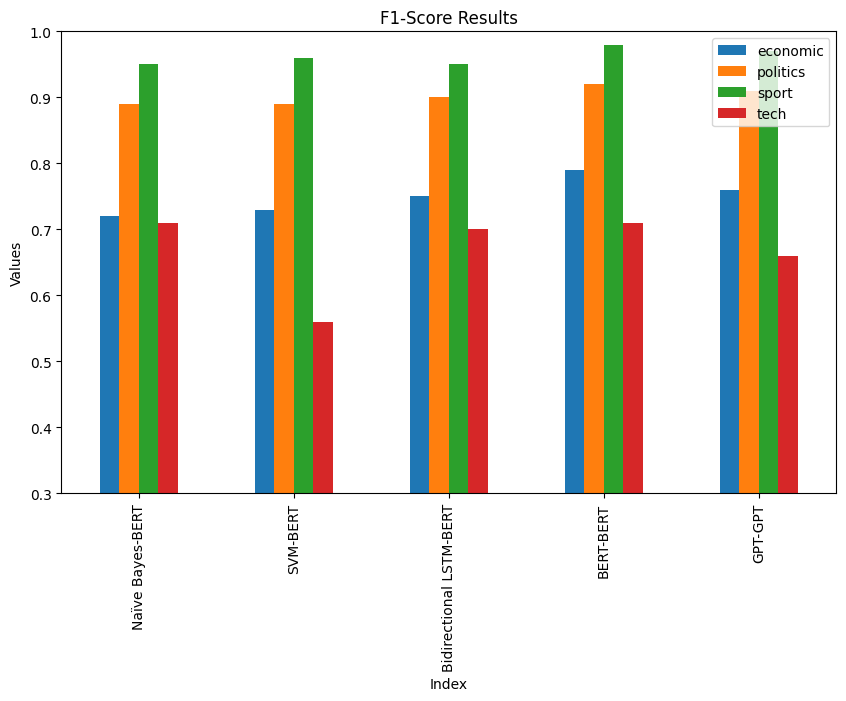

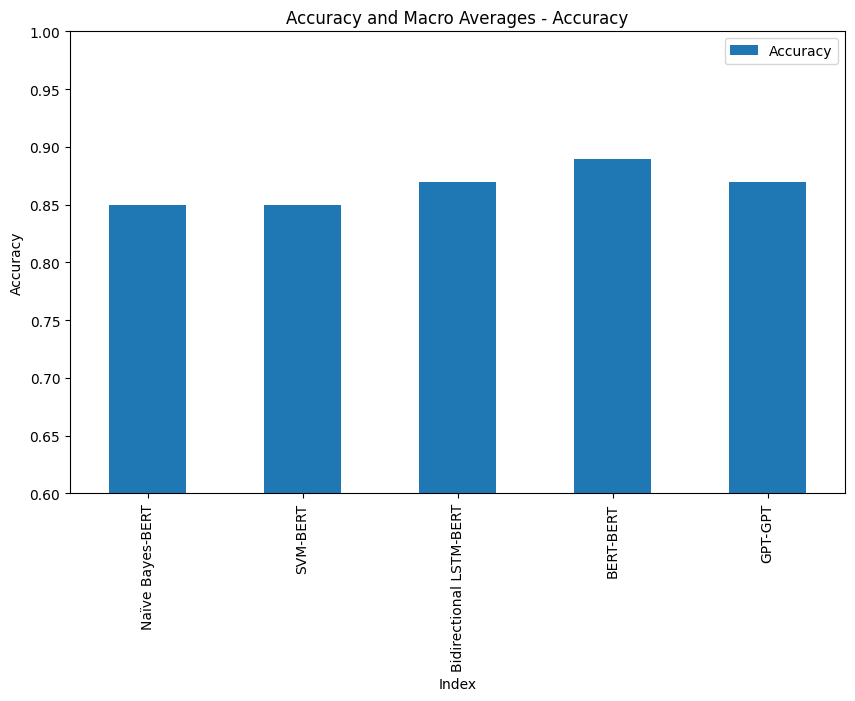

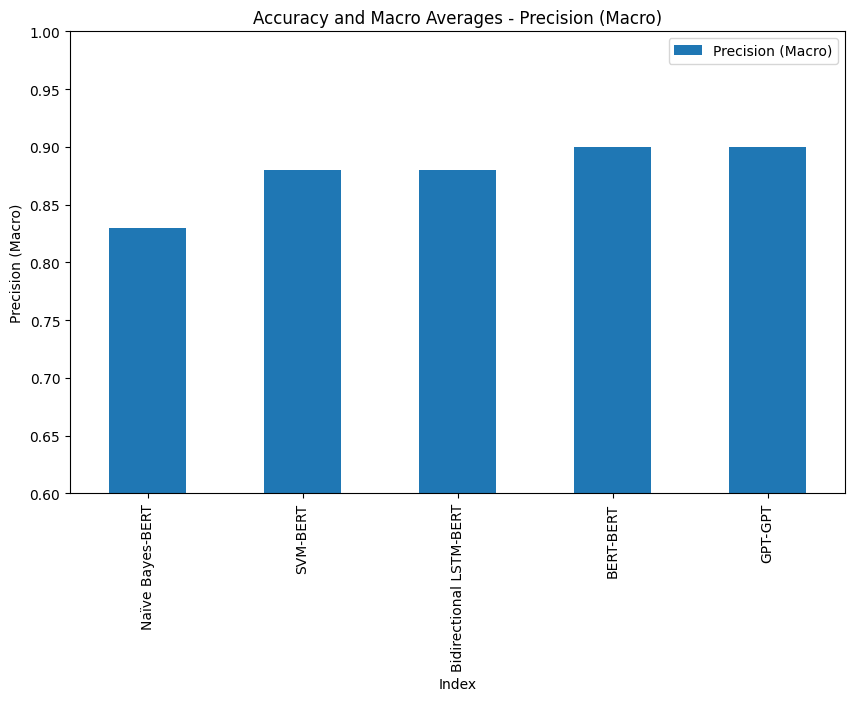

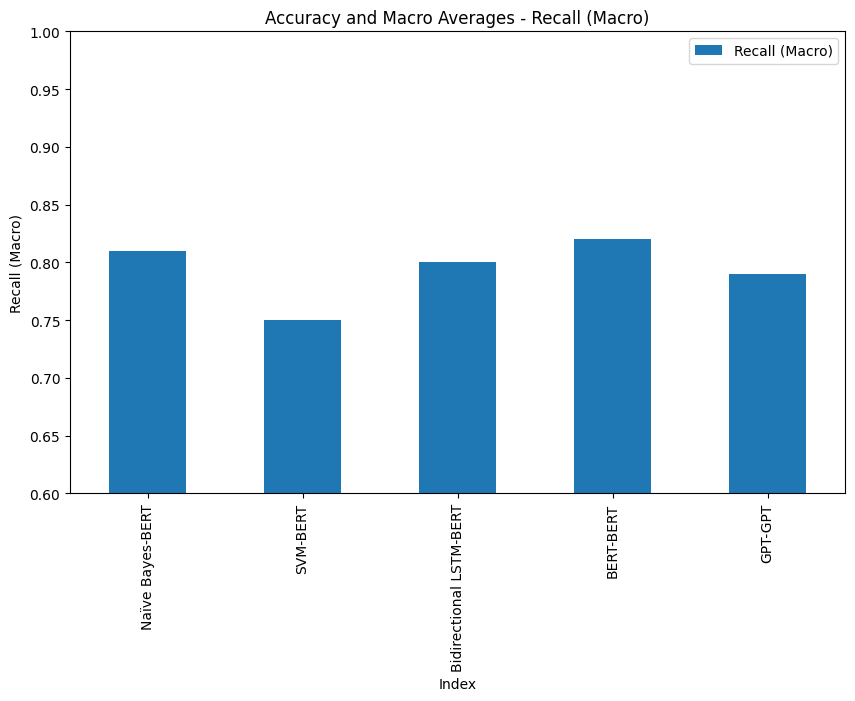

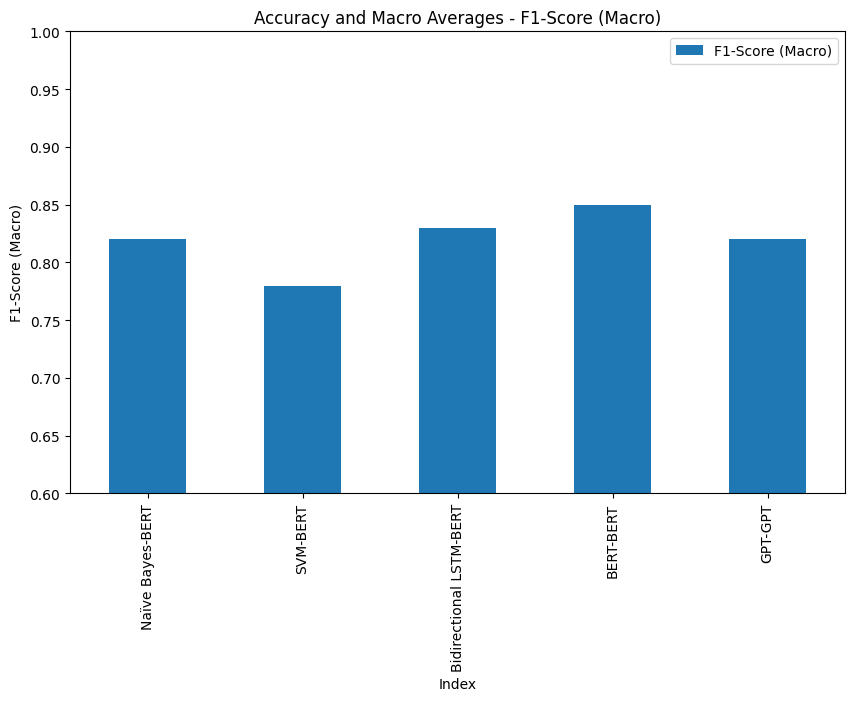

In [ ]:
for sheet in sheet_names:
    if sheet != 'Overall':
        if sheet == 'Accuracy and Macro Averages':
            plot_accuracy_and_macro_averages(sheet)
        else:
            plot_sheet_data(sheet)